# TNG Preparation

This notebook takes a halo from the [TNG 300-1](https://www.tng-project.org/about/) simulation and generates simulated X-ray observations of it using [PyXSim](https://hea-www.cfa.harvard.edu/~jzuhone/pyxsim/). This observations may then be input into Bayes-X for demonstrating and testing the analysis proceedure.

## Halo Selection

Each run has 100 snapshots avaliable, at different redshifts. However, most snapshots are stored in a minified format that lacks some of the data we used to generate simulated observations. The snapshots retained in full are:

| Snap | Scale factor | Redshift |
|:----:|:------------:|:--------:|
|   2  |    0.0769    |    12    |
|   3  |    0.0833    |    11    |
|   4  |    0.0909    |    10    |
|   6  |      0.1     |     9    |
|   8  |    0.1111    |     8    |
|  11  |     0.125    |     7    |
|  13  |    0.1429    |     6    |
|  17  |    0.1667    |     5    |
|  21  |      0.2     |     4    |
|  25  |     0.25     |     3    |
|  33  |    0.3333    |     2    |
|  40  |      0.4     |    1.5   |
|  50  |      0.5     |     1    |
|  59  |    0.5882    |    0.7   |
|  67  |    0.6667    |    0.5   |
|  72  |    0.7143    |    0.4   |
|  78  |    0.7692    |    0.3   |
|  84  |    0.8333    |    0.2   |
|  91  |    0.9091    |    0.1   |
|  99  |       1      |     0    |

In [4]:
# Specify halo here
snapshot_id = 91
halo_id = 0


In [5]:
# Load TNG API key
from dotenv import load_dotenv
from os import getenv

# This looks for a .env file in this or a parent folder and
# loads environment variables from it.
# It does not override existing env vars.
load_dotenv()

# This gets it from the environment, which may have
# been modified by load_dotenv
# You could specify it here but don't commit it to git!
api_key = getenv('TNG_API_KEY')

In [6]:
import requests
from tqdm.notebook import tqdm
from pathlib import Path
from uuid import uuid1
from os import makedirs

# The files we are working with can be large so we'll make a basic
# cache to ease the load on the TNG Project servers.


def query_cache(filename: str, cache_path=Path(".cache")):
    file_path = Path(cache_path, filename)

    if file_path.is_file():
        return True, file_path
    else:
        return False, file_path


def update_cache(filename: str, content, cache_path=Path(".cache"), overwrite=False):
    if not cache_path.is_dir():
        print(f"Making cache directory at {cache_path}")
        makedirs(cache_path)

    file_path = Path(cache_path, filename)

    if file_path.exists():
        if overwrite:
            print(f"Overwriting existing cache file {file_path}.")
        else:
            raise FileExistsError(f"Cache file {file_path} already exists.")

    write_mode = "wb"
    if isinstance(content, requests.Response):
        # Read binary/text from request and access content
        if "text" in content.headers["Content-Type"]:
            write_mode = "w"
        content = content.content
    elif isinstance(content, Path):
        # If we're passed a file just move it
        # This is good for large temp files we don't want to read into memory
        print(f"Moving {content} to cache as {file_path}")
        content.rename(file_path)
        return file_path

    with file_path.open(write_mode) as f:
        print(f"Caching {file_path}")
        f.write(content)

    return file_path


def get_halo(snapshot: int, halo: int, simulation="TNG300-1"):
    base_url = f"http://www.tng-project.org/api/{simulation}/snapshots/{snapshot}/halos/{halo}/"
    headers = {"api-key": api_key}

    base_filename = f"{simulation}_snapshot{snapshot_id}_halo{halo_id}_"

    # First get info file for halo
    info_filename = base_filename + "_info.json"
    in_cache, info_path = query_cache(info_filename)

    if not in_cache:
        info_url = base_url + "info.json"
        print(f"Downloading info.json for halo from {info_url}")
        r = requests.get(info_url, headers=headers)  # type: ignore
        r.raise_for_status()  # raise exception on error
        info_path = update_cache(info_filename, r)

    # Then get the halo cutout
    halo_filename = base_filename + "_cutout.hdf5"
    in_cache, halo_path = query_cache(halo_filename)

    if not in_cache:
        tmp_file = Path(f"tmp_{uuid1()}.hdf5")
        cutout_url = base_url + "cutout.hdf5"
        print(f"Downloading cutout for halo from {cutout_url} to {tmp_file}")
        r = requests.get(cutout_url, headers=headers, stream=True)  # type: ignore
        # Fancy progress bar
        with tqdm.wrapattr(
            open(tmp_file, "wb"),
            "write",
            miniters=1,
            desc=f"Downloading cutout",
            total=int(r.headers.get("content-length", 0)),
        ) as fout:
            for chunk in r.iter_content(chunk_size=4096):
                fout.write(chunk)
        update_cache(halo_filename, tmp_file)

    return info_path, halo_path

In [7]:
info_path, halo_path = get_halo(snapshot_id, halo_id)

In [8]:
from yt.loaders import load as load_dataset
from json import load as load_json

with info_path.open() as f:
    info = load_json(f)

ds = load_dataset(halo_path)

yt : [INFO     ] 2023-04-24 13:33:07,819 Calculating time from 9.096e-01 to be 3.934e+17 seconds
yt : [INFO     ] 2023-04-24 13:33:07,869 Parameters: current_time              = 3.934088884834162e+17 s
yt : [INFO     ] 2023-04-24 13:33:07,870 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-04-24 13:33:07,870 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-04-24 13:33:07,870 Parameters: domain_right_edge         = [205000. 205000. 205000.]
yt : [INFO     ] 2023-04-24 13:33:07,871 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-04-24 13:33:07,871 Parameters: current_redshift          = 0.09940180263022191
yt : [INFO     ] 2023-04-24 13:33:07,871 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2023-04-24 13:33:07,871 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2023-04-24 13:33:07,872 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-04-24 13:33:07,872 Parameters: hubble_const

## Plots

First we draw a couple of nice plots of the dataset. This detects the edge of the cluster (slowly) and tries to include the entire thing.

In [120]:
# type: ignore
# Set these values here so the edge radius doesn't reset every time

# From the data specs:
# GroupPos = spatial position within the periodic box (of the particle with the minimum gravitational potential energy). Comoving coordinate.
center = info['GroupPos']

dm = 1
dr = 2000
r0 = info['Group_R_Mean200']
r = r0

mt = ds.r[:,:,:].sum(('gas', 'mass'))
dx = mt

In [121]:
# type: ignore

while dx > 0.001*mt or abs(dr) > 50:
    r += dr
    sp1 = ds.sphere(center, (r+dr, "kpccm/h"))
    sp2 = ds.sphere(center, (r, "kpccm/h"))
    dx = sp1.sum(("gas", "mass")).in_units('Msun') - sp2.sum(("gas", "mass")).in_units('Msun')

    print(f"dx: {dx} at radius {r} with dr: {dr}")
    if dx == 0:
        dr = -abs(dr / 2)
    else:
        dr = min(abs(float(mt / dx * r)), r0)

sp = ds.sphere(center, (r, 'kpccm/h'))

dx: 94193572873207.62 Msun at radius 4587.525634765625 with dr: 2000
dx: 634282116218.9375 Msun at radius 7175.05126953125 with dr: 2587.525634765625
dx: 0.0 Msun at radius 9762.576904296875 with dr: 2587.525634765625
dx: -634282116218.9375 Msun at radius 8468.814086914062 with dr: -1293.7628173828125
dx: 0.0 Msun at radius 11056.339721679688 with dr: 2587.525634765625
dx: 0.0 Msun at radius 9762.576904296875 with dr: -1293.7628173828125
dx: 0.0 Msun at radius 9115.695495605469 with dr: -646.8814086914062
dx: 0.0 Msun at radius 8792.254791259766 with dr: -323.4407043457031
dx: 0.0 Msun at radius 8630.534439086914 with dr: -161.72035217285156
dx: 0.0 Msun at radius 8549.674263000488 with dr: -80.86017608642578


In [125]:
# type: ignore
from yt.visualization.plot_window import SlicePlot
from unyt import unyt_array

center_units = unyt_array(center, 'kpccm/h', registry=ds.unit_registry)

slc = SlicePlot(ds, "z", [("gas", "density"), ("gas", "temperature")], center=center_units, width=(r, 'kpccm/h'))

# slc.annotate_sphere(center_units, radius=(info["Group_R_Crit200"], "kpccm/h"))

slc.set_cmap(('gas', 'density'), 'viridis')
slc.set_cmap(('gas', 'temperature'), 'inferno')
slc.show()

yt : [INFO     ] 2023-04-24 16:07:16,311 xlim = 39030.073025 47579.747288
yt : [INFO     ] 2023-04-24 16:07:16,312 ylim = 44073.908962 52623.583225
yt : [INFO     ] 2023-04-24 16:07:16,313 xlim = 39030.067724 47579.740826
yt : [INFO     ] 2023-04-24 16:07:16,314 ylim = 44073.902977 52623.576079
yt : [INFO     ] 2023-04-24 16:07:16,316 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2023-04-24 16:07:27,885 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800


YTPlotCallbackError: annotate_sphere callback failed

In [ ]:
slc.save()

yt : [INFO     ] 2022-10-07 21:25:14,510 Saving plot cutout_300-91_Slice_z_density.png
yt : [INFO     ] 2022-10-07 21:25:15,156 Saving plot cutout_300-91_Slice_z_temperature.png


['cutout_300-91_Slice_z_density.png', 'cutout_300-91_Slice_z_temperature.png']

In [ ]:
# sp1 = ds.sphere(center, (8000, "kpc/h"))
# sp2 = ds.sphere(center, (7000, "kpc/h"))
# print((sp1.sum(("gas", "mass")).in_units('Msun') - sp2.sum(("gas", "mass")).in_units('Msun'))/sp1.sum(("gas", "mass")).in_units('Msun'))

# yt.ProfilePlot(
#     sp1, ("gas","radius"), [("gas", "density")], weight_field=None
# ).show()

In [ ]:
import pyxsim
import soxs

In [ ]:
var_elem = {
    elem: ("gas", f"{elem}_fraction")
    for elem in
    ["C", "Fe", "H", "He", "Mg", "N", "Ne", "O", "Si"]
}
source_model = pyxsim.ThermalSourceModel('apec', 0.7, 7, 400, ('PartType0', 'metallicity'), var_elem=var_elem)

In [ ]:
prefix = 'tng_'
pos = (45.,30.) # (RA, Dec)
exp_time = (300., "ks") # exposure time
area = (1000, "cm**2") # collecting area
redshift = ds.current_redshift

In [ ]:
n_photons, n_cells = pyxsim.make_photons(prefix + "photons", sp, redshift, area, exp_time, source_model)

pyxsim : [INFO     ] 2022-10-07 19:50:38,558 Cosmology: h = 0.6774 100*km/(Mpc*s), omega_matter = 0.3089, omega_lambda = 0.6911
pyxsim : [INFO     ] 2022-10-07 19:50:38,559 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2022-10-07 19:50:38,559 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/201 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/28834570 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2022-10-07 19:55:12,142 Finished generating photons.
pyxsim : [INFO     ] 2022-10-07 19:55:12,143 Number of photons generated: 19187393
pyxsim : [INFO     ] 2022-10-07 19:55:12,144 Number of cells with photons: 8420618


In [ ]:
n_events = pyxsim.project_photons(prefix + "photons", prefix + "events", "z", pos, absorb_model="tbabs", nH=0.022)
events = pyxsim.EventList(prefix + "events.h5")
events.write_to_simput(prefix, overwrite=True)

pyxsim : [INFO     ] 2022-10-07 19:55:12,201 Foreground galactic absorption: using the tbabs model and nH = 0.022.
Projecting photons from cells/particles: 100%|██████████| 8420618/8420618 [01:35<00:00, 88487.98it/s] 
pyxsim : [INFO     ] 2022-10-07 19:56:47,379 Detected 18547603 events.
soxs : [INFO     ] 2022-10-07 19:56:47,897 Writing source to tng__phlist.fits.


soxs : [INFO     ] 2022-10-07 21:19:43,584 Adding in point-source background.
soxs : [INFO     ] 2022-10-07 21:19:44,192 Detecting events from source ptsrc_bkgnd
soxs : [INFO     ] 2022-10-07 21:19:44,192 Applying energy-dependent effective area from acisi_aimpt_cy0.arf.
soxs : [INFO     ] 2022-10-07 21:19:44,211 64178 events detected.
soxs : [INFO     ] 2022-10-07 21:19:44,214 Pixeling events.
soxs : [INFO     ] 2022-10-07 21:19:44,224 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2022-10-07 21:19:44,292 22286 events were rejected because they do not fall on any CCD.
soxs : [INFO     ] 2022-10-07 21:19:44,296 Scattering energies with RMF acisi_aimpt_cy0.rmf.


Scattering energies :   0%|          | 0/41892 [00:00<?, ?it/s]

soxs : [INFO     ] 2022-10-07 21:19:44,489 Generated 41892 photons from the point-source background.
soxs : [INFO     ] 2022-10-07 21:19:44,490 Adding in astrophysical foreground.


Convolving spectrum :   0%|          | 0/937 [00:00<?, ?it/s]

soxs : [INFO     ] 2022-10-07 21:19:44,818 Adding in instrumental background.
soxs : [INFO     ] 2022-10-07 21:19:44,853 Making 16251 events from the galactic foreground.
soxs : [INFO     ] 2022-10-07 21:19:44,854 Making 365420 events from the instrumental background.
soxs : [INFO     ] 2022-10-07 21:19:44,875 Writing events to file tng_bg.fits.
soxs : [INFO     ] 2022-10-07 21:19:44,955 Making observation of source in tng_obs_evt.fits.
soxs : [INFO     ] 2022-10-07 21:19:45,193 Detecting events from source tng_
soxs : [INFO     ] 2022-10-07 21:19:45,194 Applying energy-dependent effective area from acisi_aimpt_cy0.arf.
soxs : [INFO     ] 2022-10-07 21:19:46,709 2440055 events detected.
soxs : [INFO     ] 2022-10-07 21:19:46,781 Pixeling events.
soxs : [INFO     ] 2022-10-07 21:19:47,223 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2022-10-07 21:19:48,828 678659 events were rejected because they do not fall on any CCD.
soxs : [INFO     ] 2022-10-07 21:19:48,942 Sc

Scattering energies :   0%|          | 0/1761396 [00:00<?, ?it/s]

soxs : [INFO     ] 2022-10-07 21:19:49,493 Adding background events from the file tng_bg.fits.
soxs : [INFO     ] 2022-10-07 21:19:49,501 Adding 141240 background events from tng_bg.fits.
soxs : [INFO     ] 2022-10-07 21:19:49,527 Writing events to file tng_obs_evt.fits.
soxs : [INFO     ] 2022-10-07 21:19:49,829 Observation complete.


(<Figure size 1000x1000 with 2 Axes>, <WCSAxes:>)

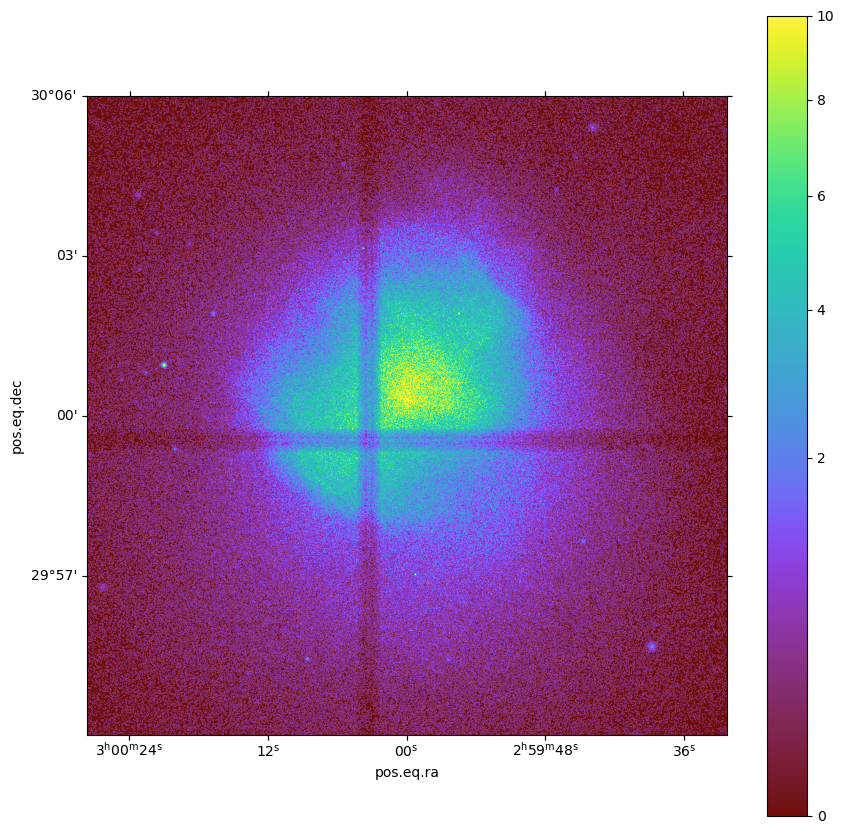

In [ ]:
soxs.make_background_file(prefix + "bg.fits", exp_time, "chandra_acisi_cy0", pos, overwrite=True)
soxs.instrument_simulator(prefix + "_simput.fits", prefix + "obs_evt.fits", (100.0, "ks"), "chandra_acisi_cy0",
                          pos, overwrite=True, bkgnd_file=prefix+'bg.fits')
soxs.write_image(prefix + "obs_evt.fits", prefix + "obs_img.fits", emin=0.7, emax=7.0, overwrite=True)
soxs.plot_image(prefix + "obs_img.fits", stretch='sqrt', cmap='arbre', vmin=0.0, vmax=10.0, width=0.2)